# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os
import numpy as np

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

FileNotFoundError: [Errno 2] No such file or directory: '../data/lab-01-data.tar.gz'

In [3]:
# All the suplementary importation
from skimage import data
from skimage.exposure import histogram
from skimage.morphology import erosion, disk, square

import numpy as np

from skimage import filters
from skimage.data import camera
from skimage.util import compare_images

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

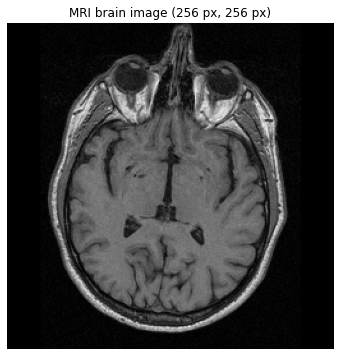

In [22]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [9]:
brain_im.shape

(256, 256)

### 1.2 Region growing


First we analyse the histogram of our image reference to have a better idea of the differente region of the image in terme of pixel intensity.

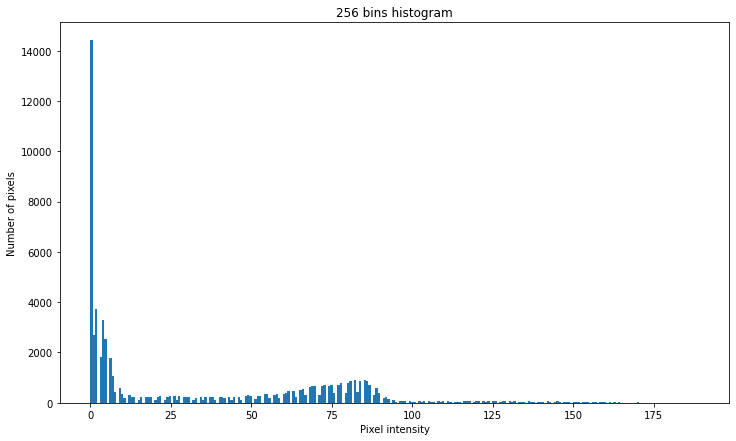

In [5]:
image_ref = brain_im
nb_bins = 256

# Display histogram
plt.figure(figsize=(12, 7))
plt.hist(image_ref.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')

plt.show()

We start studying the "stupid pixel" by finding the best threshold boundary to make the easier possible the segmentation of the brain.

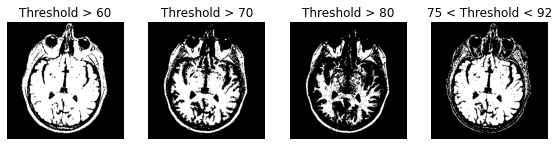

In [8]:
# Comparing Threshold selection

fig, axes = plt.subplots(1, 4, figsize=(8, 4), sharey=True)


axes[0].imshow(brain_im > 50, cmap=plt.cm.gray)
axes[0].set_title('Threshold > 60')

axes[1].imshow(brain_im > 70, cmap=plt.cm.gray)
axes[1].set_title('Threshold > 70')

axes[2].imshow(brain_im > 80, cmap=plt.cm.gray)
axes[2].set_title('Threshold > 80')


mask1 = brain_im < 95
mask2 = brain_im > 60
mask = mask1 * mask2

axes[3].imshow(mask, cmap=plt.cm.gray)
axes[3].set_title('60 < Threshold < 92')

for a in axes:
    a.axis('off')

plt.tight_layout()

After applying different threshold, we find a good region for the brain pixel between 75 and 92 of intensity.

Inspiration, pseudo code for growing region algorithm: https://dsp.stackexchange.com/questions/35138/region-growing-algorithm

In [14]:
def growRegion(image,start,threshold,oldList):
    neighbor = [[1,0],[0,1],[1,1],[-1,0],[0,-1],[-1,-1],[1,-1],[-1,1]]
    pixelList = []
    
    im_h, im_w = image.shape
    
    for point in neighbor:
        nextPosition = [start[0]+point[0],start[1]+point[1]]
        if(nextPosition[0] < im_w and nextPosition[0] > 0): # Check than it's not out of the image on x 
            if(nextPosition[1] < im_h and nextPosition[1] > 0): # Check than it's not out of the image on y
                if(image[nextPosition[0],nextPosition[1]] > 60 and image[nextPosition[0],nextPosition[1]] < 95 and nextPosition not in oldList):
                    pixelList.append(nextPosition)
                    
    return pixelList   

In [15]:
start = [94,102]
image = brain_im
threshold = 65

regionMask = []
visitedList = []
nextPoints = []


regionMask.append(start) # All the points on the regions
visitedList.append(start) 
nextPoints.append(start)

while not(not nextPoints):
    
    point = nextPoints[0]
    del nextPoints[0]
    
    outList = growRegion(image,point,threshold,visitedList)
    
    regionMask.extend(outList)
    
    nextPoints.extend(outList)
    
    visitedList.extend(outList)
    
print("End of Process") 

End of Process


The number of pixel find in the brain is: 15174
This is 23.1536865234375% of the actual image


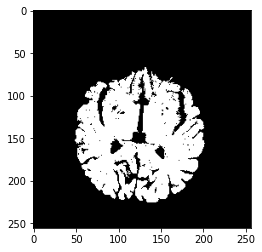

In [16]:
mask = np.zeros((256,256))
nbPixel = 0

for coord in regionMask:

    mask[coord[0],coord[1]] = 1 
    nbPixel += 1




fig, axes = plt.subplots()
axes.imshow(mask, cmap=plt.cm.gray)

ratio = nbPixel/(256*256)*100

print("The number of pixel find in the brain is:",nbPixel)
s = "This is " + repr(ratio) + "% of the actual image"
print(s)


### 1.3 Contour detection


Now we try to work with the contour. First we apply the same threshold than before, plus an erosion to improve the separation between the different contour.

Text(0.5, 1.0, 'Brain image after pre-processing')

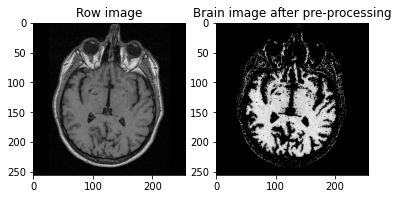

In [191]:
mask1 = brain_im > 70
mask2 = brain_im < 95
mask = mask1*mask2

preprod_image = erosion(brain_im) * mask



fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(image, cmap='gray')
ax0.set_title('Row image')
ax1.imshow(preprod_image, cmap='gray')
ax1.set_title('Brain image after pre-processing')

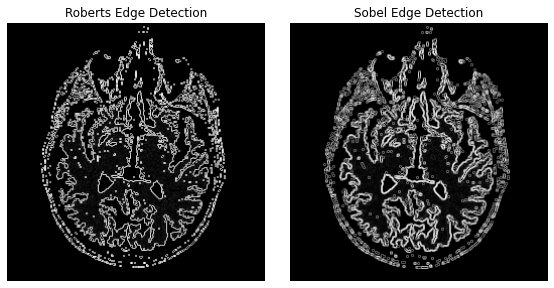

In [181]:
edge_roberts = filters.roberts(preprod_image)
edge_sobel = filters.sobel(preprod_image)

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(8, 4))

axes[0].imshow(edge_roberts, cmap=plt.cm.gray)
axes[0].set_title('Roberts Edge Detection')

axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
axes[1].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

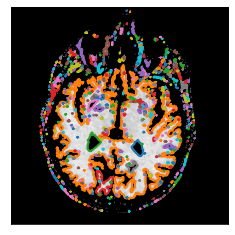

In [192]:
from skimage import measure

# Find contours at a constant value of 0.8
contours = measure.find_contours(preprod_image, 50,'high')

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(preprod_image, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

We keep the longest contour.

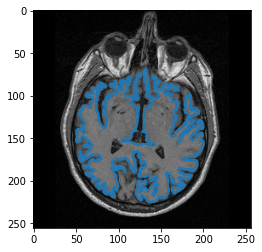

In [193]:
contour = sorted(contours, key=lambda x: len(x),reverse = True)[0]

fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(contour[:, 1], contour[:, 0], linewidth=2)


We fill this contour.

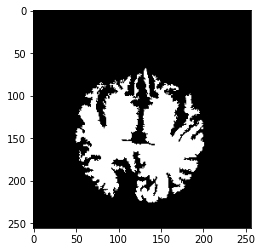

In [194]:
import scipy.ndimage as ndimage    

# Create an empty image to store the masked array
r_mask = np.zeros_like(image, dtype='bool')

# Create a contour image by using the contour coordinates rounded to their nearest integer value
r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1

# Fill in the hole created by the contour boundary
r_mask = ndimage.binary_fill_holes(r_mask)

# Invert the mask since you want pixels outside of the region
#r_mask = ~r_mask

fig, axes = plt.subplots()
axes.imshow(r_mask, cmap=plt.cm.gray)

Source: 

https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html

https://stackoverflow.com/questions/39642680/create-mask-from-skimage-contour

The number of pixel find in the brain is: 12231
This is 18.66302490234375% of the actual image


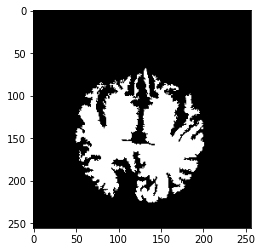

In [210]:
nbPixel = 0

for x in range(0,256):
    for y in range(0,256):
        if(r_mask[x,y] > 0):
            nbPixel += 1

fig, axes = plt.subplots()
axes.imshow(r_mask, cmap=plt.cm.gray)

ratio = nbPixel/(256*256)*100

print("The number of pixel find in the brain is:",nbPixel)
s = "This is " + repr(ratio) + "% of the actual image"
print(s)

### 1.4 Additional method(s)


We first try to mix canny contour filtering and erosion to obtain an approximation of the brain surface.

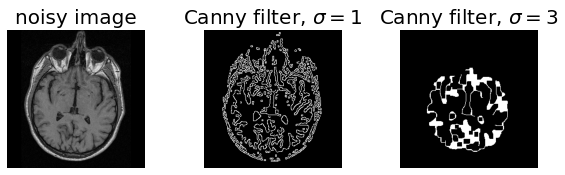

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.morphology import erosion,dilation,closing,square,opening
from skimage import feature

mask3 = brain_im > 70
mask4 = brain_im < 95
mask_canny = mask3*mask4

preprod_image = erosion(brain_im,square(1)) * mask_canny

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(preprod_image)
edges2 = feature.canny(preprod_image, sigma=3)
# try to close the contour
edges2 = closing(edges2,square(7))

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

Text(0.5, 1.0, 'Filling the holes')

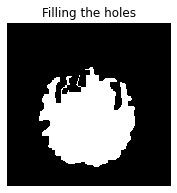

In [117]:
from scipy import ndimage as ndi

fill_contour = ndi.binary_fill_holes(edges2)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(fill_contour, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('Filling the holes')

The number of pixel find in the brain is: 15351
This is 23.42376708984375% of the actual image


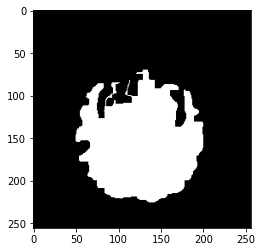

In [211]:
nbPixel = 0

for x in range(0,256):
    for y in range(0,256):
        if(fill_contour[x,y] > 0):
            nbPixel += 1

fig, axes = plt.subplots()
axes.imshow(fill_contour, cmap=plt.cm.gray)

ratio = nbPixel/(256*256)*100

print("The number of pixel find in the brain is:",nbPixel)
s = "This is " + repr(ratio) + "% of the actual image"
print(s)

Second, we try to isolate the interest region with multiples erosions and restore a part of the lost in the brain with dilation.

Text(0.5, 1.0, 'Result')

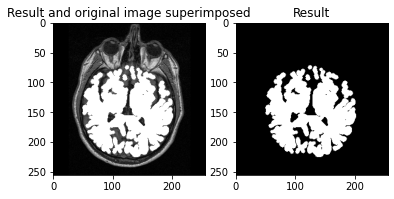

In [213]:
from skimage.morphology import erosion,dilation
from skimage.morphology import disk, square, star

brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))

back_im = brain_im

mask1 = back_im < 115
mask2 = back_im > 62
mask = mask1 * mask2
mask = erosion(mask,disk(2))
mask = erosion(mask,square(2))
mask = dilation(mask,disk(3))

back_im[mask]= 200

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(back_im, cmap='gray')
ax0.set_title('Result and original image superimposed')
ax1.imshow(mask, cmap='gray')
ax1.set_title('Result')


The number of pixel find in the brain is: 14315
This is 21.84295654296875% of the actual image


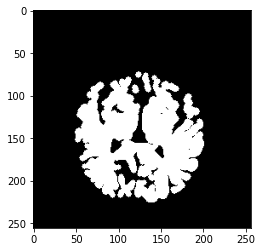

In [214]:
nbPixel = 0

for x in range(0,256):
    for y in range(0,256):
        if(mask[x,y] > 0):
            nbPixel += 1

fig, axes = plt.subplots()
axes.imshow(mask, cmap=plt.cm.gray)

ratio = nbPixel/(256*256)*100

print("The number of pixel find in the brain is:",nbPixel)
s = "This is " + repr(ratio) + "% of the actual image"
print(s)

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [1]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

NameError: name 'os' is not defined

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

In [ ]:
# extracting blue channel of each image and inverting colors (we need the objects to be against a dark background)

blue_images = []

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    blue_channel = im[..., 2]     # (480x640) matrix
    blue_channel = np.invert(blue_channel)
    blue_images.append (blue_channel)
    ax.imshow(blue_channel)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [ ]:
#plotting the normalized blue channel of each image in gray

normalized_im = []

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), blue_images, im_names):
    norm_im = skimage.exposure.match_histograms(im, blue_images[0])
    normalized_im.append(norm_im)
    ax.imshow(norm_im,cmap=plt.cm.gray)
    ax.axis('off')
    ax.set_title(nm)
plt.show(

In [ ]:
# finding the correct thresholds for the watershed algorithm

fig, ax = plt.subplots(figsize=(12, 12))
image_test = normalized_im[0]
print(image_test[270:275,200])       # blue objects
print(image_test[350:360, 60:70])    # black objects
print(image_test[0,0])               # background
ax.imshow(image_test)
plt.show()

In [ ]:
# implement region-based segmentation with watershed transform

from skimage.filters import sobel

im_markers = []
im_elevation = []

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), normalized_im, im_names):
    markers = np.zeros_like(im)
    markers[im < 95] = 1
    markers[im > 100] = 2
    im_markers.append(markers)

    elevation_map = sobel(im)
    im_elevation.append(elevation_map)
    
    ax.imshow(elevation_map)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [ ]:
from skimage.segmentation import watershed
from scipy import ndimage as ndi

segmented_im = [] # lists with 3 elements (480 by 640 matrices)
objects = []

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, mk, el, nm in zip(axes.ravel(), im_markers, im_elevation, im_names):
    segmentation = watershed(el, mk)
    segmentation = ndi.binary_fill_holes(segmentation - 1)
    
    labeled_shapes, _ = ndi.label(segmentation)
    segmented_im.append(labeled_shapes)          # label 0 corresponds to the background of the image
    unique, counts = np.unique(labeled_shapes, return_counts=True)
    objects.append(dict(zip(unique, counts)))
    print(dict(zip(unique, counts)))
    ax.imshow(segmentation)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [ ]:
from skimage.measure import regionprops
import matplotlib.patches as mpatches

#blue_objects = np.zeros(len(segmented_im))
#black_objects = np.zeros(len(segmented_im))

blue_objects = []
black_objects = []

blue_obj = []
black_obj = []

blue_pxl = np.zeros(len(segmented_im))
black_pxl = np.zeros(len(segmented_im))

fig, axes = plt.subplots(1, 3, figsize=(12, 12))

for ax, im, nm, i in zip(axes.ravel(), segmented_im, im_names, range(len(segmented_im))):

    ax.imshow(im)
    
    for region, j in zip(regionprops(im), range(len(regionprops(im)))):
         if region.area >= 100 and region.area < 2000:  # take regions corresponding to "real" objects excluding the background
            condition = im==j 
            object_pxl = np.extract(condition, normalized_im)  # extract pixels corresponding to the studied region 
            center = region.centroid
            if np.mean(object_pxl) > 150:
                blue_pxl[i] += region.area
                blue_obj.append(region)
                circ = mpatches.Circle(center, radius=5, color='white')
            else:
                black_pxl[i] += region.area
                black_obj.append(region)
                circ = mpatches.Circle(center, radius=5, color='red')
            ax.add_patch(circ)
    print("Image", nm, "has {} blue shapes and {} black shapes".format(len(blue_obj),len(black_obj)))
    
    blue_objects.append(blue_obj)
    black_objects.append(black_obj)
    blue_obj.clear()
    black_obj.clear()
    
    print("Image", nm, "has {} blue pixels and {} black pixels".format(blue_pxl[i],black_pxl[i]))
    
    ax.axis('off')
    ax.set_title(nm)
plt.show

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

In [ ]:
for nm in im_names:
    print("Image", nm, "has {} blue pixels and {} black pixels".format(blue_pxl[i],black_pxl[i]))